### Reproducing results 
This notebook reproduces deterministic soliton-soliton interactions specified in Kasssam-Trefethen 2005 initial conditions.
Then a basic machine learning method is attempted and fails

In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

float64


Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [2]:
signal_params = ConfigDict(KDV_params)
print(signal_params)
#signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 256,P=0,S=0) to update the parameters

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 2.0e-06
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 5000
nx: 256
tmax: 0.01
xmax: 3.141592653589793
xmin: -3.141592653589793



In [3]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

In [4]:
key = jax.random.PRNGKey(0)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key) #the final input is scan length? 

In [5]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)

(1, 256)
(5000, 1, 256)


In [6]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,0,:], color='k')
    plt.legend(['signal'])
    plt.show()

interact(plot, da_step=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=2500, description='da_step', max=5000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

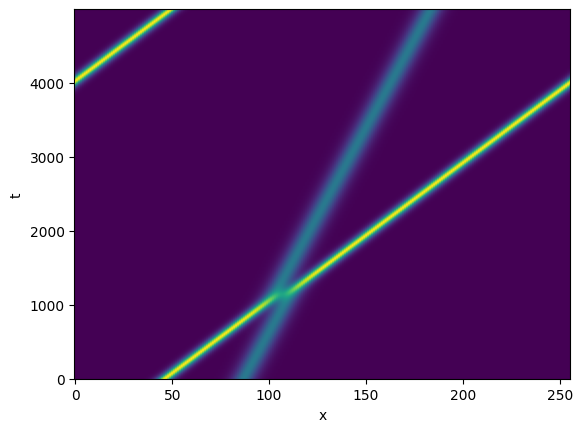

In [7]:
plt.imshow(all[:,0,:], aspect='auto',origin='lower')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [14]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
from typing import List, Callable, Optional
import pickle


# ---- KS-style data generator ----
def create_data(nx,steps,dt,key):
    Tmax = steps*dt
    signal_params = ConfigDict(KDV_params)
    signal_params.update(nx=nx,dt=dt,nt=steps,tmax=Tmax)

    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)# update after the reinitialization of params

    print(signal_model.params)
    
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key)
    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    return signal[0,0,:], signal[1:,0,:]


# ---- Simple feedforward model ----
class Forecaster(eqx.Module):
    
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear

    def __init__(self, width, key):
        key1, key2 = jax.random.split(key)
        self.layer1 = eqx.nn.Linear(width, width, key=key1)
        self.layer2 = eqx.nn.Linear(width, width, key=key2)

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        return self.layer2(x)

class SimpleMLP(eqx.Module):
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear
    layer3: eqx.nn.Linear

    def __init__(self, width, key):
        k1, k2, k3 = jax.random.split(key, 3)
        self.layer1 = eqx.nn.Linear(width, width, key=k1)
        self.layer2 = eqx.nn.Linear(width, width, key=k2)
        self.layer3 = eqx.nn.Linear(width, width, key=k3)

    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = jax.nn.relu(self.layer2(x))
        return self.layer3(x)

class SimpleFeedforward(eqx.Module):
    layer1: eqx.nn.Linear
    layer2: eqx.nn.Linear
    layer3: eqx.nn.Linear
    layer4: eqx.nn.Linear
    layer5: eqx.nn.Linear
    def __init__(self, width, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        self.layer1 = eqx.nn.Linear(width, width, key=key1)
        self.layer2 = eqx.nn.Linear(width, width, key=key2)
        self.layer3 = eqx.nn.Linear(width, width, key=key3)
        self.layer4 = eqx.nn.Linear(width, width, key=key4)  # Additional layer for deeper architecture
        self.layer5 = eqx.nn.Linear(width, width, key=key5)  # Additional layer for deeper architecture
    def __call__(self, x):
        x = jax.nn.relu(self.layer1(x))
        x = jax.nn.relu(self.layer2(x))
        x = jax.nn.relu(self.layer3(x))
        x = jax.nn.relu(self.layer4(x))
        x = self.layer5(x)  # No activation on output layer
        return x
    
# ---- Rollout function ----
def rollout(model, u0, steps):
    def step_fn(carry, _):
        u_next = model(carry)
        return u_next, u_next
    _, us = jax.lax.scan(step_fn, u0, None, length=steps)
    return us  # (steps, N)


# ---- Loss ----
def loss_fn(model, u0, u_true):
    u_pred = rollout(model, u0, u_true.shape[0])
    return jnp.mean((u_pred - u_true) ** 2)


@eqx.filter_value_and_grad
def compute_loss(model, u0, u_true):
    return loss_fn(model, u0, u_true)

@jax.jit
def train_step(model, opt_state, u0, u_true):
    loss, grads = compute_loss(model, u0, u_true)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


# ---- Main loop ----
nx = 64
steps = 100
dt = 0.00001  # Time step for the signal model
u0, u_true = create_data(nx = nx, steps=steps, dt=dt, key=jax.random.PRNGKey(42))
print(f"Using initial signal shape: {u0.shape}, true signal shape: {u_true.shape}")
key = jax.random.PRNGKey(42)
#model = Forecaster(width=nx, key=key)
model = SimpleFeedforward(width=64, key=key)  # Use SimpleFeedforward instead of Forecaster
# ---- Training step ----
optimizer = optax.adam(1e-3)  # Using Adam optimizer with weight decay
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
for epoch in range(501):
    model, opt_state, loss = train_step(model, opt_state, u0, u_true)
    params = eqx.filter(model, eqx.is_inexact_array)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.6f}")




Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 1.0e-05
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 100
nx: 64
tmax: 0.001
xmax: 3.141592653589793
xmin: -3.141592653589793

Using initial signal shape: (64,), true signal shape: (100, 64)
Epoch 0: loss = 84188.248984
Epoch 100: loss = 84007.176317
Epoch 200: loss = 68203.331154
Epoch 300: loss = 65761.309350
Epoch 400: loss = 63559.911890
Epoch 500: loss = 61425.936153


In [41]:
optimizer = optax.adam(1e-5)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
for epoch in range(5001):
    model, opt_state, loss = train_step(model, opt_state, u0, u_true)
    params = eqx.filter(model, eqx.is_inexact_array)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.6f}")

Epoch 0: loss = 46010.805312
Epoch 100: loss = 71579.513085
Epoch 200: loss = 61446.754794
Epoch 300: loss = 80143.462181
Epoch 400: loss = 81182.699853
Epoch 500: loss = 73512.669424
Epoch 600: loss = 80690.348418
Epoch 700: loss = 75635.400746
Epoch 800: loss = 57062.520511
Epoch 900: loss = 52805.001635
Epoch 1000: loss = 50531.009040
Epoch 1100: loss = 80427.760059
Epoch 1200: loss = 82481.045526
Epoch 1300: loss = 82454.484040
Epoch 1400: loss = 82201.394411
Epoch 1500: loss = 81579.887735
Epoch 1600: loss = 65686.142294
Epoch 1700: loss = 58486.131188
Epoch 1800: loss = 54458.586452
Epoch 1900: loss = 51376.262612
Epoch 2000: loss = 49693.945758
Epoch 2100: loss = 48276.021954
Epoch 2200: loss = 46960.086660
Epoch 2300: loss = 45868.591616
Epoch 2400: loss = 45398.810403
Epoch 2500: loss = 45036.724635
Epoch 2600: loss = 44657.377155
Epoch 2700: loss = 44280.094191
Epoch 2800: loss = 43923.163600
Epoch 2900: loss = 43657.496508
Epoch 3000: loss = 80356.907783
Epoch 3100: loss = 8

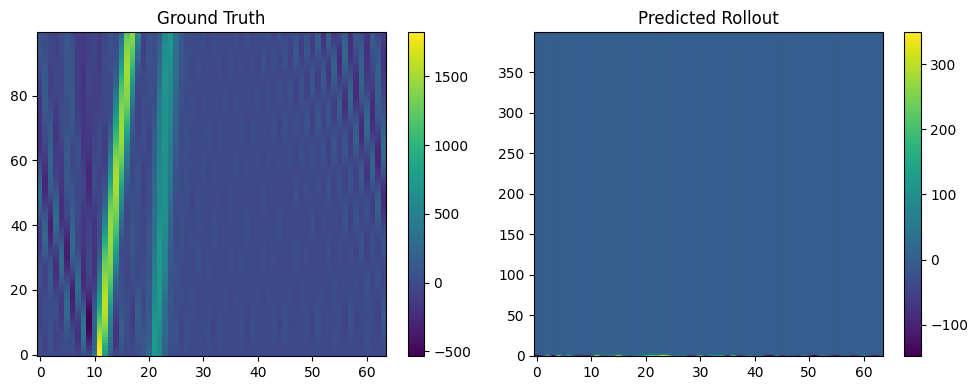

In [42]:
def plot_rollout(u_true, u_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im1 = axes[0].imshow(u_true, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title("Ground Truth")
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(u_pred, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title("Predicted Rollout")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()
    
u_pred = rollout(model, u0, steps)

plot_rollout(u_true, u_pred)


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: Kassam_Trefethen_KdV_IC_eq3pt1
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 400
nx: 64
tmax: 0.04
xmax: 3.141592653589793
xmin: -3.141592653589793



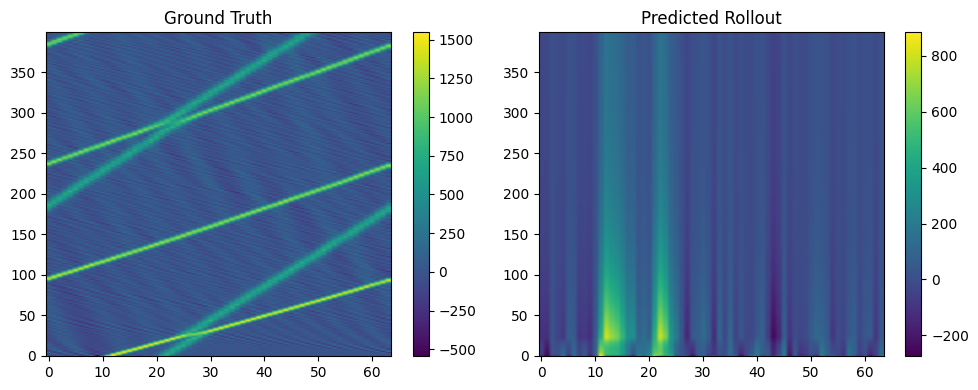

In [40]:
N = 64
steps = 400
dt = 0.0001  # Time step for the signal model
u0, u_true_long = create_data(nx=N, steps=steps, dt=dt, key=jax.random.PRNGKey(42))
u_pred = rollout(model, u0, steps)
plot_rollout(u_true_long, u_pred)




In [37]:
import ipywidgets as widgets

u_true_long 
u_pred
def plot_comparison(step):
    plt.figure(figsize=(10, 4))
    plt.plot(u_true_long[step], label='Ground Truth')
    plt.plot(u_pred[step], label='Prediction')
    plt.title(f"Step {step}")
    plt.legend()
    plt.show()

widgets.interact(plot_comparison, step=(0, u_true_long.shape[0] - 1))

interactive(children=(IntSlider(value=199, description='step', max=399), Output()), _dom_classes=('widget-inte…

<function __main__.plot_comparison(step)>